#### 2.2.1. Defining the World

In [1]:
# Set-up the pylab context
%pylab inline
random.seed(0)
# Import libraries that will be used
import copy
import math
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# This is a 3 X 4 Grid World represented by a 3 x 4 array
# Each array location contains a character representing:
#    O = Open location for the agent to traverse
#    B = Location that cannot be traversed by the agent 
#    W = Ending location with the agent winning
#    L = Ending location with the agent losing
world = [['O','O','O','W'],  
         ['O','B','O','L'],
         ['O','O','O','O']]

#### 2.2.2. Setting the Rewards

In [3]:
# Mapping of current state to reward value
rewards = {}

# Positive reward for entering the win state
rewards['W'] = 1.0 

# Negative reward for entering lost state
rewards['L'] = -1.0 

# No reward for all other states
rewards['O'] = 0.0 
rewards['B'] = 0.0

#### 2.2.3. Initializing the Value Function

In [4]:
# Value function that defines the utility of being 
# in a particular state in the 3 X 4 grid world, 
# initialized to zero
utility = [[0.0,0.0,0.0,0.0],
           [0.0,0.0,0.0,0.0],
           [0.0,0.0,0.0,0.0]]

# Function to reset all utility values to 0
def reset_util(utility):
    for xx in xrange(len(utility)):
        for yy in xrange(len(utility[xx])):
            utility[xx][yy] = 0.0

#### 2.2.4. Updating the Value Function

In [5]:
# Discount factor (gamma) applied to future rewards
# Smaller value indicates less importance
discount_factor = 1.0

# Updates the utility of a particular grid location given 
#   x,y-coordinate in the world, 
#   current utility values, 
#   world representation, 
#   and the rewards
def update_utility(xx, yy, utility, world):
    
    # Determine the reward for this grid location
    reward = rewards[world[xx][yy]]
        
    # If the world location is blocked, it cannot be visited and has 0 utility
    if(world[xx][yy] == 'B'):
        return 0.0
    
    # If the world location is either the winning or losing, its utility is its reward
    if(world[xx][yy] == 'W' or world[xx][yy] == 'L'):
        return reward
    
    # Else, the utility is the reward of the current location plus the discounted maximum utility from this location 
    return reward + discount_factor * max_utility(xx, yy, utility, world)

In [6]:
# Updates the utility of each grid location 
# given the current utility values and the world
def update_all_utility(utility, world):
    for xx in range(3):
        for yy in range(4):
            utility[xx][yy] = update_utility(xx, yy, utility, world)

#### 2.2.5. Determining the Action with Max Utility

In [7]:
# In the grid world, the probability of success 
# indicates the chance the movement (e.g. Up)
# actually moves up, with a failure resulting
# in a perpendicular direction (e.g. Left or Right)
prob_action_success = 0.8 

# Gets the max utility from the current location in the world
# By observing the utility of each of the action posibilities
# (Up, Down, Left, Right) and selecting the max
def max_utility(xx, yy, utility, world):
    
    # Get the utility from moving up
    # which inludes failures going left and right
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    up_utility = prob_action_success * action_utility(xx, yy, -1, 0, utility, world) 
    up_utility = up_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, -1, utility, world)
    up_utility = up_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, 1, utility, world)
    
    # Get the utility from moving down
    # which inludes failures going left and right
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    down_utility = prob_action_success * action_utility(xx, yy, 1, 0, utility, world) 
    down_utility = down_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, -1, utility, world)
    down_utility = down_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, 1, utility, world)
    
    # Get the utility from moving left
    # which inludes failures going up and down
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    left_utility = prob_action_success * action_utility(xx, yy, 0, -1, utility, world) 
    left_utility = left_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, -1, 0, utility, world)
    left_utility = left_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 1, 0, utility, world)
    
    # Get the utility from moving right
    # which inludes failures going up and down
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    right_utility = prob_action_success * action_utility(xx, yy, 0, 1, utility, world) 
    right_utility = right_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, -1, 0, utility, world)
    right_utility = right_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 1, 0, utility, world)
    
    # Return the max of these utilities
    return max(up_utility, down_utility, right_utility, left_utility)

A helper function is implemented here to address certain edge cases (e.g. moving left from the left most of the world, attempting to move to a blocked grid location).

In [8]:
# Compute the utility of the new state 
# given a successful action taken from 
# the current state 
def action_utility(xx, yy, xxd, yyd, utility, world):
    
    # Edge cases where the action would move
    # outside the grid world results in staying
    # in the current location
    if(xx + xxd < 0 or xx + xxd > 2 or yy + yyd < 0 or yy + yyd > 3):
        return utility[xx][yy]
    
    # Edge cases where the action would move
    # to a blocked location results in staying
    # at the current location
    if(world[xx + xxd][yy + yyd] == 'B'):
        return utility[xx][yy]
    
    # Normal case, action moves to new state
    # and utility is from the new state
    return utility[xx + xxd][yy + yyd]

#### 2.2.6. Creating Policies

In [9]:
# Policy mapping defines an action
# to be taken for each state in the
# environment
# In the grid world, these actions are to move:
#   U = Up 
#   D = Down
#   L = Left, 
#   R = Right, 
#   N = Not Applicable (Invalid/End States)
policy = [['U', 'U', 'U', 'N'],
          ['U', 'N', 'U', 'N'],
          ['U', 'U', 'U', 'U']]

In [10]:
# Return the best action to take
# from the current state
# given the current value-function and world
def best_action(xx, yy, utility, world):
    
    # No applicable action if the state puts us in a blocked
    # or ending position
    if(world[xx][yy] == 'B' or world[xx][yy] == 'W' or world[xx][yy] == 'L' ):
        return 'N'
    
    # Get the utility from moving up
    # which inludes failures going left and right
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    up_utility = prob_action_success * action_utility(xx, yy, -1, 0, utility, world)
    up_utility = up_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, -1, utility, world)
    up_utility = up_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, 1, utility, world)
    
    # Get the utility from moving down
    # which inludes failures going left and right
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    down_utility = prob_action_success * action_utility(xx, yy, 1, 0, utility, world) 
    down_utility = down_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, -1, utility, world)
    down_utility = down_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 0, 1, utility, world)

    # Get the utility from moving left
    # which inludes failures going up and down
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    left_utility = prob_action_success * action_utility(xx, yy, 0, -1, utility, world) 
    left_utility = left_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, -1, 0, utility, world)
    left_utility = left_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 1, 0, utility, world)
    
    # Get the utility from moving right
    # which inludes failures going up and down
    # Any other state contributes 0 to the utility
    # Because they have probability of 0
    right_utility = prob_action_success * action_utility(xx, yy, 0, 1, utility, world) 
    right_utility = right_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, -1, 0, utility, world)
    right_utility = right_utility + (1 - prob_action_success)/2 * action_utility(xx, yy, 1, 0, utility, world)

    # Initialize the best action
    # to be the first action (Up)
    best_action = 'U'
    
    # Set the maximum utility
    # from any action to up's utility
    max_utility = up_utility
    
    # If moving down has more utility
    if(down_utility > max_utility):
        
        # Set the best action to Down
        max_utility = down_utility
        best_action = 'D'
    
    # If moving left has more utility
    if(left_utility > max_utility):
        
        # Set the best action to Left
        max_utility = left_utility
        best_action = 'L'
    
    #If moving right has the best utility
    if(right_utility > max_utility):
        # Set the best action to Right
        max_utility = right_utility
        best_action = 'R'
        
    # Return the action that maximizes utility
    return best_action

In [11]:
# Updates the policy with the actions 
# that provide the best utility for each state
def update_policy(policy, world, utility):
    for xx in range(3):
        for yy in range(4):
            policy[xx][yy] = best_action(xx, yy, utility, world)

#### 2.2.7. Running the Algorithm

In [12]:
# Performs a number of iterations
# of the value iteration algorithm
def value_iteration(iterations):
    
    # For the number of iterations
    for xx in range(iterations):
        
        # Update the value function
        update_all_utility(utility, world)
        # Update the policy
        update_policy(policy, world, utility)
    
    # Print out the value function
    for xx in range(3):
        print utility[xx]
    print

    # Print out the policy
    for xx in range(3):
        print policy[xx]

Now examine how the algorithm updates the value function and policy by varying the number of iterations.

In [13]:
# Function that will reset the utility values
# and then perform a number of iterations of
# the value iteration approach
def interactive_iteration(iterations=1):
    reset_util(utility)
    value_iteration(iterations)

# Create an interactive slider for 
# the number of iterations
interact(interactive_iteration, iterations=(0, 100, 1))

[0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 0.0, -1.0]
[0.0, 0.0, 0.0, 0.0]

['U', 'U', 'R', 'N']
['U', 'N', 'L', 'N']
['U', 'U', 'U', 'D']


<function __main__.interactive_iteration>

#### 2.2.8. Playing with Parameters

#### Reward Values

In [14]:
# Function that will reset the utility values
# and then perform the value iteration 
# approach with the parameters
def interactive_iteration(winning_reward=1.0,
                          losing_reward=-1.0,
                          intermediate_reward=0.0,
                          iterations=1000):
    # Reward for entering the win state
    rewards['W'] = winning_reward  
    # Reward for entering the lose state
    rewards['L'] = losing_reward
    # Reward for entering an open location
    rewards['O'] = intermediate_reward
    reset_util(utility)
    value_iteration(iterations)
    
# Create interactive sliders for 
# the rward values
interact(interactive_iteration, winning_reward=(0.0, 1.0, 0.05),
                                losing_reward=(-1.0, 0.0, 0.05),
                                intermediate_reward=(-1.0, 1.0, 0.05),
                                iterations=(0,1000,10))

[1.0, 1.0, 1.0, 1.0]
[1.0, 0.0, 0.9999999999999998, -1.0]
[1.0, 1.0, 1.0, 0.9999999999999992]

['U', 'U', 'U', 'N']
['U', 'N', 'L', 'N']
['U', 'U', 'L', 'D']


<function __main__.interactive_iteration>

#### Discount Factor

In [15]:
# Function that will reset the utility values
# and then perform the value iteration 
# approach with the parameters
def interactive_iteration(discount=1.0,
                          winning_reward=1.0,
                          losing_reward=-1.0,
                          intermediate_reward=0.0,
                          iterations=1000):
    # Reward for entering the win state
    rewards['W'] = winning_reward  
    # Reward for entering the lose state
    rewards['L'] = losing_reward
    # Reward for entering an open location
    rewards['O'] = intermediate_reward
    global discount_factor
    discount_factor = discount
    reset_util(utility)
    value_iteration(iterations)
    
# Create interactive sliders for 
# the rward values
interact(interactive_iteration, discount=(0.0, 1.0, 0.05),
                                winning_reward=(0.0, 1.0, 0.05),
                                losing_reward=(-1.0, 0.0, 0.05),
                                intermediate_reward=(-1.0, 1.0, 0.05),
                                iterations=(0,1000,10))

[1.0, 1.0, 1.0, 1.0]
[1.0, 0.0, 0.9999999999999998, -1.0]
[1.0, 1.0, 1.0, 0.9999999999999992]

['U', 'U', 'U', 'N']
['U', 'N', 'L', 'N']
['U', 'U', 'L', 'D']


<function __main__.interactive_iteration>

#### Transition Probabilities

In [16]:
# Function that will reset the utility values
# and then perform the value iteration 
# approach with the parameters
def interactive_iteration(success=1.0,
                          discount=0.8,
                          winning_reward=1.0,
                          losing_reward=-1.0,
                          intermediate_reward=0.0,
                          iterations=1000):
    # Reward for entering the win state
    rewards['W'] = winning_reward  
    # Reward for entering the lose state
    rewards['L'] = losing_reward
    # Reward for entering an open location
    rewards['O'] = intermediate_reward
    global discount_factor
    discount_factor = discount
    global prob_action_success
    prob_action_success = success
    reset_util(utility)
    value_iteration(iterations)
    
# Create interactive sliders for 
# the rward values
interact(interactive_iteration, success=(0.0, 1.0, 0.05),
                                discount=(0.0, 1.0, 0.05),
                                winning_reward=(0.0, 1.0, 0.05),
                                losing_reward=(-1.0, 0.0, 0.05),
                                intermediate_reward=(-1.0, 1.0, 0.05),
                                iterations=(0,1000,10))

[0.5120000000000001, 0.6400000000000001, 0.8, 1.0]
[0.40960000000000013, 0.0, 0.6400000000000001, -1.0]
[0.32768000000000014, 0.40960000000000013, 0.5120000000000001, 0.40960000000000013]

['R', 'R', 'R', 'N']
['U', 'N', 'U', 'N']
['U', 'R', 'U', 'L']


<function __main__.interactive_iteration>

#### 2.3a.1 Interacting with the World

In [17]:
# Starting state
# Represents the row and column
# the agent starts at in the grid world
start_x = 2
start_y = 0

# Current state
# Represents the row and column
# the agent is currently at in the grid world
# Initialized to the start state
cur_x = start_x
cur_y = start_y

In [18]:
# Function that performs an action
# in the grid world and then returns
# the new state
# Available actions are (U)p, (D)own, (L)eft, and (R)ight
def perform_action(xx, yy, action):
    
    # If in any of these states, cannot move from them (Blocked, Win, Lost)
    if(world[xx][yy] == 'B' or world[xx][yy] == 'W' or world[xx][yy] == 'L'):
        # Reamin at current location
        return xx,yy
    
    # Determine if move does not succeed with given probability
    if(random.uniform(0, 1) > prob_action_success):
        
        # If original action is up or down, 
        # change the action to left on failure
        if(action == 'U' or action == 'D'):
            action = 'L'
        
        # Else original action is left or right
        # change the action to up
        else:
            action = 'U'
        
        # Flip the direction of the failure
        # with equal probability (e.g. either
        # fail left/right, or up/down)
        if(random.uniform(0, 1) < 0.5):
            # Reverse directions
            if(action == 'U'):
                action = 'D'
            else:
                action = 'R'
    
    # Set the new state values
    # to the current state values
    new_x = xx
    new_y = yy
    
    # Perform the movement by
    # adding/substracting from
    # appropriate state variables
    if(action == 'U'):
        new_x = new_x - 1
    elif(action == 'D'):
        new_x = new_x + 1
    elif(action == 'L'):
        new_y = new_y - 1
    elif(action == 'R'):
        new_y = new_y + 1
    
    # If the new state is out of bounds, 
    # or trying to move to a blocked location
    # return the original state
    if(new_y < 0 or new_y > 3 or new_x < 0 or new_x > 2):
        return xx,yy
    if(world[new_x][new_y] == 'B'):
        return xx,yy
    
    # Return the new state
    return new_x,new_y

#### 2.3a.2 The Q-Table

In [19]:
# Q-table that contains the
# approximation of the state-action 
# value function
q_values = {}

# Each action maps to a matrix of values
# that represent the value of taking
# that action in a particular state
# Thus, q_values['U'][1][3] returns the
# approximate reward for moving Up
# when in the 1st row, 3rd column
q_values['U'] = [[0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]]
q_values['D'] = [[0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]]
q_values['L'] = [[0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]]
q_values['R'] = [[0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]]

# Function to initialize the q-table
# entries to a particular value
def init_qtable(init_value):
    for xx in range(3):
        for yy in range(4):
            q_values['U'][xx][yy] = init_value
            q_values['D'][xx][yy] = init_value
            q_values['L'][xx][yy] = init_value
            q_values['R'][xx][yy] = init_value

#### 2.3a.3 Choosing Actions

In [20]:
# Rate of selecting action at random, 
# rather than greedy selection
epsilon = 0.1

# Chooses an action through the epsilon greedy approach
def choose_action(xx, yy, q_table):
    
    # If we choose at random
    if(random.uniform(0,1) < epsilon):
        # Select Up, Down, Left, or Right
        # in a uniform random manner
        selection = random.uniform(0,1)
        if(selection < 0.25):
           return 'U'
        elif(selection < 0.5):
           return 'R'
        elif(selection < 0.75):
           return 'D'
        else:
            return 'L'
        
    # Else select the best action possible (greedy)
    return best_action(xx, yy, q_table)

In [21]:
# Selects the best action 
# at the given state through the given q-table
def best_action(xx, yy, q_table):
    best = 'U'
    if(q_table[best][xx][yy] < q_table['R'][xx][yy]):
        best = 'R'
    if(q_table[best][xx][yy] < q_table['D'][xx][yy]):
        best = 'D'
    if(q_table[best][xx][yy] < q_table['L'][xx][yy]):
        best = 'L'
    return best

#### 2.3a.4 Updating the Q-values

In [22]:
# Learning rate of (alpha) Q-Learning
learning_rate = 0.9
# Discount factor (gamma) applied to future rewards
discount_factor = 0.9

# Updates the Q-table given the current state, action taken,
# and the next state according the the learning rate
# and discoutn factor
def update_q_table(q_table, xx1, yy1, action, xx2, yy2):    
    
    # If it is a final state
    if(world[xx1][yy1] != 'O'):
        # The q-value is simply the reward
        q_table[action][xx1][yy1] = rewards[world[xx1][yy1]]
        return
    
    # Find the optimal action of the next state
    best = best_action(xx2, yy2, q_table)
    
    # Find the update value for the Q value
    update = learning_rate * (rewards[world[xx1][yy1]] + discount_factor * q_table[best][xx2][yy2] - q_table[action][xx1][yy1])
    
    # Update the Q value for the action at the original state
    q_table[action][xx1][yy1] = q_table[action][xx1][yy1] + update

#### 2.3a.5 Deriving Policy from Q-values

In [23]:
# Updates the optimal policy with the optimal actions given the Q-values
def update_policy(policy, q_values):
    for xx in range(3):
        for yy in range(4):
            policy[xx][yy] = 'N'
            if(world[xx][yy] == 'O'):
                policy[xx][yy] = best_action(xx,yy,q_values)

#### 2.3a.5 Assembling the Q-Learning Algorithm

In [24]:
# This function performs q-learning
# for a given number of iterations
def q_learn(iterations):
  
    cur_x = start_x
    cur_y = start_y
    
    # For the number of iterations
    for ii in range(iterations): 
        
        # Choose an action (epsilon greedy)
        action = choose_action(cur_x, cur_y, q_values)
        
        # Perform the action and move to the new state
        new_x, new_y = perform_action(cur_x, cur_y, action)
        
        # Update the Q-table
        update_q_table(q_values, cur_x, cur_y, action, new_x, new_y)
        
        # If in the end state, reset to the starting state
        if(cur_x == new_x and cur_y == new_y and world[cur_x][cur_y] != 'O'):
            new_x = start_x
            new_y = start_y
            
            
        # Set the current state to the new state
        cur_x,cur_y = new_x,new_y

#### 2.3a.6 Playing with Parameters

There are two new parameters introduced into the Q-Learning paradigm: The learning rate, $\alpha$, and the randomness parameter, $\epsilon$. Change epsilon to accelerate the rate of exploration and the learning rate to change how quickly the Q values update with new information.  Other paramters from the value iteration approach remain and can have significant effect on Q-Learning.  Explore these interactions below.

In [25]:
# Function that will reset the utility values
# and then perform the value iteration 
# approach with the parameters
def interactive_iteration(learning = 0.25,
                          randomness = 0.1,
                          success=0.85,
                          discount=0.9,
                          winning_reward=1.0,
                          losing_reward=-1.0,
                          intermediate_reward=0.0,
                          iterations=1000):
    global learning_rate
    learning_rate = learning
    global epsilon
    epsilon = randomness
    # Reward for entering the win state
    rewards['W'] = winning_reward  
    # Reward for entering the lose state
    rewards['L'] = losing_reward
    # Reward for entering an open location
    rewards['O'] = intermediate_reward
    global discount_factor
    discount_factor = discount
    global prob_action_success
    prob_action_success = success
    
    # Initializes the Q-table to be all 1's
    init_qtable(1.0)

    # Performs Q-Learning for iterations
    q_learn(iterations)

    # Updates the policy based on the Q-table
    update_policy(policy, q_values)

    # Print the Q-values for each action
    print 'Up'
    for xx in range(3):
        print q_values['U'][xx]
    print
    print 'Down'
    for xx in range(3):
        print q_values['D'][xx]
    print
    print 'Left'
    for xx in range(3):
        print q_values['L'][xx]
    print
    print 'Right'
    for xx in range(3):
        print q_values['R'][xx]
    print

    # Print out the policy
    print 'Policy'
    for xx in range(3):
        print policy[xx]   
    
# Create interactive sliders for 
# the rward values
interact(interactive_iteration, learning=(0.0, 1.0, 0.05),
                                randomness=(0.0, 1.0, 0.05),
                                success=(0.0, 1.0, 0.05),
                                discount=(0.0, 1.0, 0.05),
                                winning_reward=(0.0, 1.0, 0.05),
                                losing_reward=(-1.0, 0.0, 0.05),
                                intermediate_reward=(-1.0, 1.0, 0.05),
                                iterations=(0,10000,10))

Up
[0.621859537540582, 0.714952209582199, 0.7936105382351634, 1.0]
[0.5946769994279927, 1.0, 0.355263412612579, -1.0]
[0.5130052798895135, 0.4993956018359645, 0.5057558203007874, 0.14097656249999996]

Down
[0.6277221333794637, 0.7210168254632072, 0.7861713543589691, 1.0]
[0.5427913904351125, 1.0, 0.29473396134991925, -1.0]
[0.5191610734265535, 0.4937339998967918, 0.5102737631933609, 0.38956473208561687]

Left
[0.6257708156217959, 0.7057587772371022, 0.7654121356407445, 1.0]
[0.5434161177172525, 1.0, 0.46193908894933183, -1.0]
[0.5083086951364864, 0.49531969988411373, 0.504203827563532, 0.29399569543482196]

Right
[0.688037746655844, 0.803814956070581, 0.8990541944849713, 1.0]
[0.5436050989670752, 1.0, 0.12104099121093753, -1.0]
[0.5157512387345407, 0.4903070816791288, 0.5024634692746159, 0.31466129038573865]

Policy
['R', 'R', 'R', 'N']
['U', 'N', 'L', 'N']
['D', 'U', 'D', 'D']


<function __main__.interactive_iteration>

In [26]:
# Updates the Q-table given the current state, action taken, and the next state
def update_q_table_sarsa(q_table, xx1, yy1, action1, xx2, yy2, action2):    
    
    # If in a final state
    if(world[xx1][yy1] != 'O'):
        # Q-value is the reward
        q_table[action1][xx1][yy1] = rewards[world[xx1][yy1]]
        return
    
    # Find the update value for the Q value
    update = learning_rate * (rewards[world[xx1][yy1]] + discount_factor * q_table[action2][xx2][yy2] - q_table[action1][xx1][yy1])
    
    # Update the Q value for the action at the original state
    q_table[action1][xx1][yy1] = q_table[action1][xx1][yy1] + update

In [27]:
# This function performs SARSA
# for a given number of iterations
def sarsa(iterations):
  
    cur_x = start_x
    cur_y = start_y
    prev_x = start_x
    prev_y = start_y
    prev_action = -1
        
    # For the number of iterations
    for ii in range(iterations): 
        
        # Choose an action (epsilon greedy)
        next_action = choose_action(cur_x, cur_y, q_values)
        
        if(prev_action != -1):
            # Update the Q-table
            update_q_table_sarsa(q_values, prev_x, prev_y, prev_action, cur_x, cur_y, next_action)
      
        
        # Perform the action and move to the new state
        new_x, new_y = perform_action(cur_x, cur_y, next_action)
        
        # If in the end state, reset to the starting state
        if(cur_x == new_x and cur_y == new_y and world[cur_x][cur_y] != 'O'):
            new_x = start_x
            new_y = start_y
            prev_action = -1
        
        # Set the current state to the new state
        prev_action = next_action
        prev_x,prev_y = cur_x,cur_y
        cur_x,cur_y = new_x,new_y

In [28]:
# Function that will reset the utility values
# and then perform the value iteration 
# approach with the parameters
def interactive_iteration(learning = 0.2,
                          randomness = 0.1,
                          success=0.85,
                          discount=0.8,
                          winning_reward=1.0,
                          losing_reward=-1.0,
                          intermediate_reward=0.0,
                          iterations=1000):
    global learning_rate
    learning_rate = learning
    global epsilon
    epsilon = randomness
    # Reward for entering the win state
    rewards['W'] = winning_reward  
    # Reward for entering the lose state
    rewards['L'] = losing_reward
    # Reward for entering an open location
    rewards['O'] = intermediate_reward
    global discount_factor
    discount_factor = discount
    global prob_action_success
    prob_action_success = success
    
    # Initializes the Q-table to be all 1's
    init_qtable(1.0)

    # Performs Q-Learning for iterations
    sarsa(iterations)

    # Updates the policy based on the Q-table
    update_policy(policy, q_values)

    # Print the Q-values for each action
    print 'Up'
    for xx in range(3):
        print q_values['U'][xx]
    print
    print 'Down'
    for xx in range(3):
        print q_values['D'][xx]
    print
    print 'Left'
    for xx in range(3):
        print q_values['L'][xx]
    print
    print 'Right'
    for xx in range(3):
        print q_values['R'][xx]
    print

    # Print out the policy
    print 'Policy'
    for xx in range(3):
        print policy[xx]   
    
# Create interactive sliders for 
# the rward values
interact(interactive_iteration, learning=(0.0, 1.0, 0.05),
                                randomness=(0.0, 1.0, 0.05),
                                success=(0.0, 1.0, 0.05),
                                discount=(0.0, 1.0, 0.05),
                                winning_reward=(0.0, 1.0, 0.05),
                                losing_reward=(-1.0, 0.0, 0.05),
                                intermediate_reward=(-1.0, 1.0, 0.05),
                                iterations=(0,10000,10))

Up
[0.45339651514206036, 0.5308122407917384, 0.6176122689699697, 1.0]
[0.3731150319648532, 1.0, 0.39627113486589405, -1.0]
[0.30472168195933386, 0.33361273011970716, 0.3391667127960812, 0.13364684118549383]

Down
[0.4475188008706931, 0.5117324366319225, 0.5377367040616423, 1.0]
[0.3563372887100199, 1.0, 0.306791100712437, -1.0]
[0.3016427549986527, 0.32005371618029266, 0.33925446760340894, 0.3062482469113198]

Left
[0.45091561186589535, 0.5379982238941952, 0.6671920703578803, 1.0]
[0.3592481336113023, 1.0, 0.3019400241066775, -1.0]
[0.2957356495274001, 0.32869921054910306, 0.34496971704483986, 0.3096317217370775]

Right
[0.4536782841983616, 0.5650159484079366, 0.7462270586451809, 1.0]
[0.3542268333324606, 1.0, 0.0466827485624797, -1.0]
[0.29483415449569755, 0.33677142535128013, 0.34523401478512356, 0.30191208337238584]

Policy
['R', 'R', 'R', 'N']
['U', 'N', 'U', 'N']
['U', 'R', 'R', 'L']


<function __main__.interactive_iteration>

### 3.2 Constructing an Evolutionary Algorithm

#### 3.2.1. The Genome

In [29]:
# Genome class encapsulates information about a genome
# including fitness and the genetic representation 
# of the solution plus useful utility functions
class Genome: 
    # Initializer for new genome instance
    def __init__(self, fitness, genes):
        # Set the instance's fitness to the given fitness
        self.fitness = fitness
        # Set the instance's genese to the given genes
        self.genes = genes 
    
    # Creates a deep clone of the genome
    def clone(self): 
        # Uses copy's deepcopy function to create a deep copy of this Genome instance
        return copy.deepcopy(self) 

In this case, the genome consists of a fitness value and a set of genes.  For the next few experiments, we will define the set of genes as a single value $x\in\mathbb{R}$.  Below, we define a function to generate a new, random genome with $x\in[-1,1]$.

In [30]:
# Creates and returns a new random genome
def new_genome():   
    # A random genome for this domain is a real valued number (-1, 1)
    return Genome(-10000, random.uniform(-1, 1)) 

#### 3.2.2. Evaluating Performance

In [31]:
# Evaluator that returns fitness of the genome
def evaluate(genome): 
    # This fitness is equal to 1 - x^2
    genome.fitness = 1.0 - genome.genes * genome.genes 

#### 3.2.3. (un)Natural Selection

#### Selecting Parents

In [32]:
# Selects the given number of parents from the given population
def select_parents(population, number): 
    
    # Initialize an empty list of parents
    parents = []  
    
    # Get the number of individuals in the given population
    populationSize = len(population)
    
    # For the number of parents
    for x in range(number): 
        
        # Select a random genome from the population
        # with uniform probability to be a parent
        parents.append(population[random.randint(populationSize)]) 
    
    # Return the parents list
    return parents 

#### Selecting: The Next Generation

In [33]:
# Select a new population of individuals from the current and offspring
def select_population(currentPopulation, offspring): 
    
    # Get the size of the current population
    popSize = len(currentPopulation)
    
    # Initialize an empty list for the new population
    newPopulation = [] 
    
    # Combine the current and offspring populations
    currentPopulation.extend(offspring) 
    
    # Get the combined size of current and offspring populations
    combinedSize = len(currentPopulation)
    
    # Until the population for the next generation
    # is the size of the current population
    # keep selecting genomes
    while(len(newPopulation) < popSize): 
        
        # Select an index for the first candidate genome
        candidateOneIdx = random.randint(combinedSize)  
        # Select an index for the second candidate genome
        candidateTwoIdx = random.randint(combinedSize)  
        
        # If the same index is selected
        if(candidateOneIdx == candidateTwoIdx): 
            # Increment second index by one and make sure it is within bounds
            candidateTwoIdx = (candidateTwoIdx + 1)%combinedSize
            
        # Set the selected genome to the first candidate
        selected = currentPopulation[candidateOneIdx]  
        
        # If the second candidate's fitness is better
        # set it to be selected
        if(currentPopulation[candidateTwoIdx].fitness > selected.fitness): 
            selected = currentPopulation[candidateTwoIdx]
            
        # Add the selected genome to the new population
        # and remove it from the pool of candidates
        newPopulation.append(selected) 
        currentPopulation.remove(selected)
        
        # Decrement the pool count
        combinedSize -= 1
        
    # Return the new population
    return newPopulation 

#### 3.2.4. Creating Offspring

In [34]:
# Takes in a set of parents and produces 
# an equivalent number of offspring
def reproduce(parents):
    
    # Initialize an empty list of offspring
    offspring = [] 
    
    # For each parent, create a clone
    # and mutate the clone
    for parent in parents: 
        
        # Clone the parent to produce a child
        child = parent.clone() 
        
        # Set its fitness to a very low value
        child.fitness = -10000 
        
        # Mutate the clone child
        mutate_genome(child) 
        
        # Add the child to the offspring list
        offspring.append(child) 
        
    # Return the list of offspring
    return offspring 

In [35]:
# Mutation takes a genome and alters 
# its genes to create a new solution instance
def mutate_genome(genome): 
    
    # This mutatation adds a value between 
    # -0.01 and 0.01 to the genome's genes
    genome.genes += random.uniform(-0.01, 0.01) 

#### 3.2.5. The Loop of Evolution

In [36]:
# Function will run a set number of iterations of evolution
# with a given population size and number of offspring
# to create each generation
def evolution(populationSize, offspringSize, maxGenerations):
    
    # Current generation being executed
    currentGeneration = 0 
    
    # Array to hold generational average fitness values
    avgFitnessByGeneration = [] 
    # Array to hold generational champion fitness values
    bestFitnessByGeneration = [] 
    # Array to hold generational champion values
    championValuesByGeneration = [] 
    
    # Initialize an empty population
    population = []  
    # Set the best genome to a null value
    bestGenome = None 
    
    # Initialize variable for calculating population average fitness to 0
    avg = 0.0  
    
    # Create and evaluate an initial population
    # of genomes
    for x in range(populationSize):
        
        # Create new random genome and add it to the population
        population.append(new_genome())
        # Evaluate that new genome
        evaluate(population[x]) 
        # Add its fitness score to the average
        avg += population[x].fitness 
        
        # If the best genome hasn't been set, or, this
        # genome has better fitness
        if(bestGenome is None or population[x].fitness > bestGenome.fitness):  
            
            # Set the bestGenome to this genome
            bestGenome = population[x] 
    
    # Add the metrics to their various arrays for tracking
    avgFitnessByGeneration.append(avg/populationSize)
    bestFitnessByGeneration.append(bestGenome.fitness)
    championValuesByGeneration.append(bestGenome.genes)
    
    # Until the maxmium number of generations 
    # is performed
    while(currentGeneration < maxGenerations): 
        
        # Select a number of parents equal 
        # to the number of offspring to be created
        parents = select_parents(population, offspringSize)
        
        # Create a number of offspring by 
        # reproducing the selected parents
        offspring = reproduce(parents) 
        
        # Evaluate each of the offspring
        for child in offspring:
            
            evaluate(child) 
            
            # Update the best genome is applicable
            if(child.fitness > bestGenome.fitness): 
                bestGenome = child
        
        # Select a new population from the 
        # current population and offspring
        population = select_population(population, offspring) 
        
        # Initialize average to 0
        avg = 0.0 
        
        # Sum the fitness of the population
        for genome in population: 
            avg += genome.fitness 
   
        # Add the metrics to the various arrays
        avgFitnessByGeneration.append(avg/populationSize)
        bestFitnessByGeneration.append(bestGenome.fitness)
        championValuesByGeneration.append(bestGenome.genes)
        
        # Increment current generation by one
        currentGeneration += 1 
    
    # Evolution Loop Done
    
    # Plot the best fitness, average fitness, and the champion gene values by generation
    labels = range(len(bestFitnessByGeneration))
    subplot(2,1,1)
    plot(labels, bestFitnessByGeneration, labels, avgFitnessByGeneration)
    ylabel("Fitness")
    legend(["Best", "Avg."], loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    subplot(2,1,2)
    plot(labels, championValuesByGeneration)
    ylabel("Gene Values")
    
    # Return the best genome
    return bestGenome 

#### 3.2.6. Test Run

Champion -- Genes = -1.4561887015e-06 Fitness = 0.999999999998


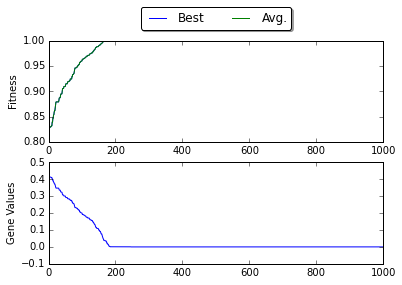

In [37]:
# Run evolution with a population of size 1
# and creting 1 offspring per generation
# for 1000 generations
winner = evolution(1, 1, 1000)

# Print out the best genome's genese and fitness
print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))


### 3.3. Exercises

#### 3.3.1. The Evaluation (Fitness) Function

Champion -- Genes = 0.78539584142 Fitness = 0.999996716238


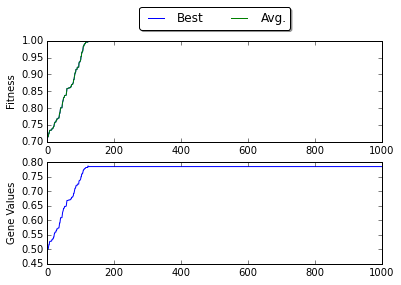

In [38]:
# Function to evaluate a genome's fitness
def evaluate(genome):
    genome.fitness = 1.0 / (1.0 + abs(math.cos(genome.genes) - math.sin(genome.genes)))

winner = evolution(1, 1, 1000)
print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))

#### 3.3.2. Growing the Population

#### Population Size ($\mu$)

Champion -- Genes = 0.785405351252 Fitness = 0.999989834942


<function __main__.interactive_iteration>

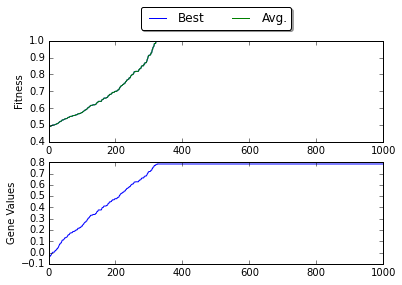

In [39]:
# Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=1):
    if(mu == 0):
        mu = 1
    winner = evolution(mu, 1, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10))

#### Offspring Size ($\lambda$)

Champion -- Genes = 0.78541540472 Fitness = 0.999975617682


<function __main__.interactive_iteration>

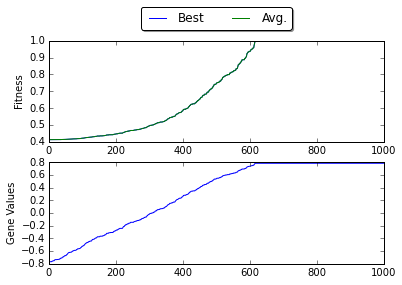

In [40]:
# Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=1,
                          lamb=1):
    if(mu == 0):
        mu = 1
    if(lamb == 0):
        lamb = 1
    winner = evolution(mu, lamb, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### Exercise: Explore the interaction between $\mu$ and $\lambda$

Champion -- Genes = 2.92080006793 Fitness = 0.238485484497


<function __main__.interactive_iteration>

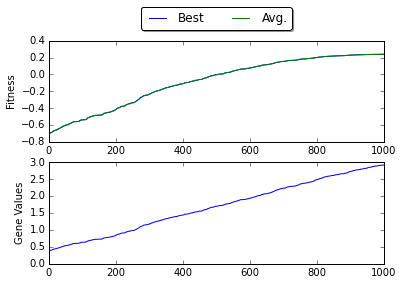

In [41]:
def evaluate(genome):
    genome.fitness = math.cos(genome.genes + 3) / (1.0 + abs(genome.genes))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### 3.3.3. Selecting the best!

#### The Pool of Candidates

In [42]:
# Select a new population of individuals from the current and offspring
def select_population(currentPopulation, offspring): 
    
    # Get the size of the current population
    popSize = len(currentPopulation)
    
    # Initialize an empty list for the new population
    newPopulation = [] 
    
    # Combine the current and offspring populations
    currentPopulation.extend(offspring) 
    
    # Get the combined size of current and offspring populations
    combinedSize = len(currentPopulation)
    
    # Until the population for the next generation
    # is the size of the current population
    # keep selecting genomes
    while(len(newPopulation) < popSize): 
        
        # Select an index for the first candidate genome
        candidateOneIdx = random.randint(combinedSize)  
        # Select an index for the second candidate genome
        candidateTwoIdx = random.randint(combinedSize)  
        
        # If the same index is selected
        if(candidateOneIdx == candidateTwoIdx): 
            # Increment second index by one and make sure it is within bounds
            candidateTwoIdx = (candidateTwoIdx + 1)%combinedSize
            
        # Set the selected genome to the first candidate
        selected = currentPopulation[candidateOneIdx]  
        
        # If the second candidate's fitness is better
        # set it to be selected
        if(currentPopulation[candidateTwoIdx].fitness > selected.fitness): 
            selected = currentPopulation[candidateTwoIdx]
            
        # Add the selected genome to the new population
        # and remove it from the pool of candidates
        newPopulation.append(selected) 
        currentPopulation.remove(selected)
        
        # Decrement the pool count
        combinedSize -= 1
        
    # Return the new population
    return newPopulation 

Champion -- Genes = 2.9173498145 Fitness = 0.238381878276


<function __main__.interactive_iteration>

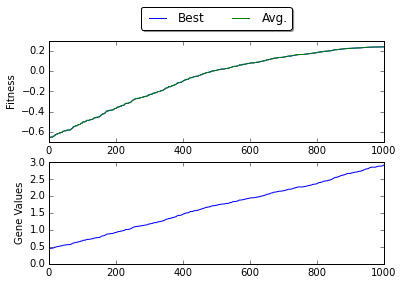

In [43]:
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### Methods of Selection

In [44]:
# Select a new population of individuals from the current and offspring
def select_population(currentPopulation, offspring): 
    
    # Get the size of the current population
    popSize = len(currentPopulation) 
    
    # Initialize an empty list for the new population
    newPopulation = [] 
    
    # Combine the current and offspring populations
    currentPopulation.extend(offspring) 
    
    # Get the combined size of current and offspring populations
    combinedSize = len(currentPopulation)
    
    # Until we have selected to the population size
    while(len(newPopulation) < popSize): 
        
        # Select indicies for the candidate genomes
        candidateOneIdx = random.randint(combinedSize)  
        candidateTwoIdx = random.randint(combinedSize)  
        candidateThreeIdx = random.randint(combinedSize)
        
        # If all three indicies are the same
        if(candidateOneIdx == candidateTwoIdx and candidateOneIdx == candidateThreeIdx):
            
            # Increment second index by one,
            # make sure it is within bounds
            # and increment the third index
            # by two
            candidateTwoIdx = (candidateTwoIdx + 1)%combinedSize 
            candidateThreeIdx = (candidateThreeIdx + 2)%combinedSize
        
        # If first and second index are the same
        if(candidateOneIdx == candidateTwoIdx): 
            # Increment second index by one
            candidateTwoIdx = (candidateTwoIdx + 1)%combinedSize
            
        # If first and third index are the same
        if(candidateOneIdx == candidateThreeIdx): 
            # Increment third index by one
            candidateThreeIdx = (candidateThreeIdx + 1)%combinedSize
            
        # If second and third index are the same
        if(candidateTwoIdx == candidateThreeIdx): 
            # Increment third index by one
            candidateThreeIdx = (candidateThreeIdx + 1)%combinedSize   
        
        # Set the selected genome to the first candidate
        selected = currentPopulation[candidateOneIdx]  
        
        # If the second candidate's fitness is better
        # Set selected to the second candidate
        if(currentPopulation[candidateTwoIdx].fitness > selected.fitness): 
            selected = currentPopulation[candidateTwoIdx] 
        
        # If the third candidate's fitness is better
        # Set selected to the third candidate
        if(currentPopulation[candidateThreeIdx].fitness > selected.fitness): 
            selected = currentPopulation[candidateThreeIdx]
            
        # Add the selected genome to the new population
        newPopulation.append(selected) 
        # Remove the selected genome from the current population
        currentPopulation.remove(selected)
        # Decrement the size of the current population by one
        combinedSize -= 1 
        
    # Return the new population    
    return newPopulation 

Champion -- Genes = 2.59236078169 Fitness = 0.214544406478


<function __main__.interactive_iteration>

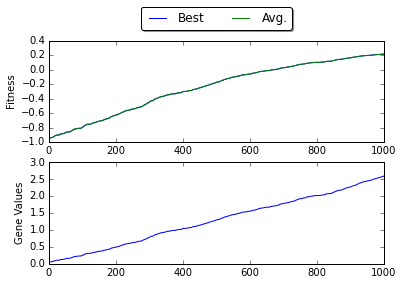

In [45]:
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### Selecting Parents

In [46]:
# Selects the given number of parents from the given population
def select_parents(population, number): 
    
    # Initialize an empty list of parents
    parents = []  
    
    # Get the number of individuals in the given population
    populationSize = len(population)
    
    # For the number of parents
    for x in range(number): 
        
        # Select a random genome from the population
        # with uniform probability to be a parent
        parents.append(population[random.randint(populationSize)]) 
    
    # Return the parents list
    return parents 

In [47]:
# Selects the given number of parents from the given population
def select_parents(population, number):
    
    # Initialize an empty list of parents
    parents = []  
    # Get the number of individuals in the given population
    populationSize = len(population) 
    
    # For the number of parents
    for x in range(number): 
        
        # Select indicies for the candidate parents
        candidateOneIdx = random.randint(populationSize)  
        candidateTwoIdx = random.randint(populationSize)  
        
        # Set selected to the first choice
        selected = population[candidateOneIdx]
        
        # If second choice has better fitness
        # Set selected to the second choice
        if(selected.fitness < population[candidateTwoIdx].fitness): 
            selected = population[candidateTwoIdx]
            
        # Add the selected parent
        parents.append(selected) 
        
    # Return the parents list
    return parents 

# Select a new population of individuals from the current and offspring
def select_population(currentPopulation, offspring):
    
    # Get the size of the current population
    popSize = len(currentPopulation)
    # Initialize an empty list for the new population
    newPopulation = [] 
    
    # Combine the current and offspring populations
    currentPopulation.extend(offspring) 
    # Get the combined size of current and offspring populations
    combinedSize = len(currentPopulation) 
    
    # Until we reach the correct population size
    while(len(newPopulation) < popSize):
        
        # Select index for candidate
        candidateOneIdx = random.randint(combinedSize)
        
        # Get the selected genome
        selected = currentPopulation[candidateOneIdx]
        
        # Add the selected genome to the new population
        newPopulation.append(selected) 
        
        # Remove the selected genome from the current population
        currentPopulation.remove(selected)
        
        # Decrement the size of the candidate pool by one
        combinedSize -= 1 
        
    # Return the new population    
    return newPopulation 

Champion -- Genes = 0.662223882808 Fitness = -0.521894415379


<function __main__.interactive_iteration>

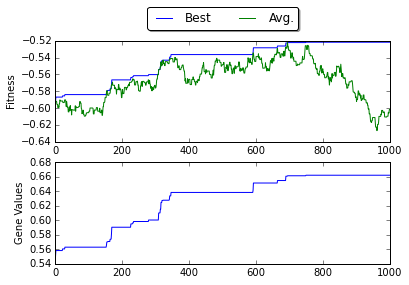

In [48]:
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### 3.3.4. Reproduction: Where baby solutions come from...

In [49]:
# Creates a new genome with two
# real-valued numbers are genes
# with a range of [-3,3]
def new_genome():
    
    # Initialize genes to an empty list
    genes = []  
    
    # Add one value between -3 and 3 as the first gene
    genes.append(random.uniform(-3, 3)) 
    # Add a second value between -3 and 3 as the second gene
    genes.append(random.uniform(-3, 3)) 
    
    # Create a new genome
    return Genome(-10000, genes)  

# Evaluation of the genome is to
# maximize a function of two variables
def evaluate(genome):
    genome.fitness = -math.log(abs((100*(genome.genes[0]**2 - genome.genes[1])**2 + (1 - genome.genes[0])**2)) + 1)

#### Mutation: Copying with error

In [50]:
# Mutates a multiple real-value
# genome
def mutate_genome(genome):
    
    # Select one of the real-values uniform randomly
    geneToMutateIdx = random.randint(len(genome.genes))
    
    # Perturbs that value by adding random value in [-0.01, 0.01]
    genome.genes[geneToMutateIdx] += random.uniform(-0.01, 0.01)

Champion -- Genes = [-2.4758100496040414, -1.0840864715395624] Fitness = -8.55965088719


<function __main__.interactive_iteration>

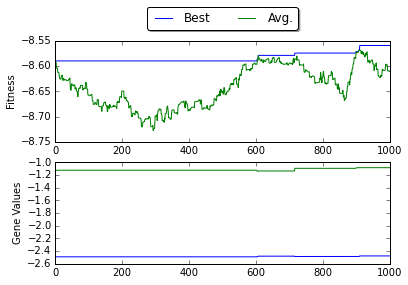

In [51]:
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

#### Mutation Power

In [52]:
# Mutates a multiple real-value
# genome
def mutate_genome(genome):
    
    # Select one of the real-values uniform randomly
    geneToMutateIdx = random.randint(len(genome.genes))
    
    # Perturbs that value by adding random value in [-10, 10]
    genome.genes[geneToMutateIdx] += random.uniform(-10, 10)

Champion -- Genes = [-0.29452749160656033, 0.40849583940898615] Fitness = -2.56710616952


<function __main__.interactive_iteration>

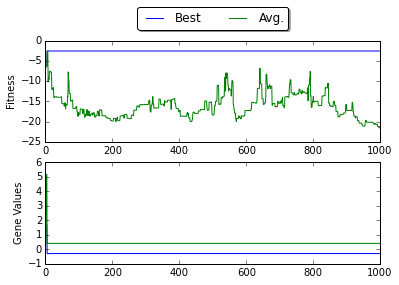

In [53]:
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10))

In [54]:
power = 0.1

# Mutates a multiple real-value
# genome
def mutate_genome(genome):
    
    # Select one of the real-values uniform randomly
    geneToMutateIdx = random.randint(len(genome.genes))
    
    # Perturbs that value by adding random value in [-power, power]
    genome.genes[geneToMutateIdx] += random.uniform(-power, power)

Champion -- Genes = [1.9920588383386146, 3.9738777313785603] Fitness = -0.686773720847


<function __main__.interactive_iteration>

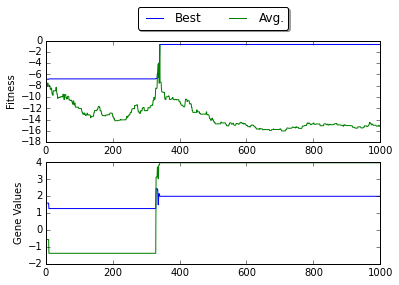

In [55]:
# Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=1,
                          lamb=1,
                          mutation_power=1.0):
    if(mu == 0):
        mu = 1
    if(lamb == 0):
        lamb = 1
    global power
    power = mutation_power
    winner = evolution(mu, lamb, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10),
                                mutation_power=(0, 10, 0.05))

#### Distribution of Mutations

In [56]:
sigma = 0.1

# Mutates a multiple real-value
# genome
def mutate_genome(genome):
    
    # Select one of the real-values uniform randomly
    geneToMutateIdx = random.randint(len(genome.genes))
    
    # Perturbs that value by adding random value in [-power, power]
    genome.genes[geneToMutateIdx] += random.normal(sigma)

Champion -- Genes = [1.3799093683774757, 1.9417167809765248] Fitness = -0.251115422239


<function __main__.interactive_iteration>

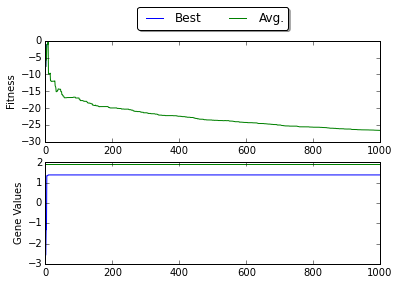

In [57]:
# Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=1,
                          lamb=1,
                          mutation_power=1.0):
    if(mu == 0):
        mu = 1
    if(lamb == 0):
        lamb = 1
    global power
    power = mutation_power
    global sigma
    sigma = mutation_power
    winner = evolution(mu, lamb, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10),
                                mutation_power=(0, 10, 0.05))

#### Mutation Rate

In [58]:
pMutateGene = 0.75

def mutate_genome(genome):
    # For each gene
    for x in range(len(genome.genes)): 
        # Randomly decide if the gene is to be mutated
        if(random.uniform(0, 1) < pMutateGene): 
            # Mutate this gene
            genome.genes[x] += random.normal(0, sigma) 

Champion -- Genes = [1.0446059103275755, 1.0956619607692346] Fitness = -0.00397135494421


<function __main__.interactive_iteration>

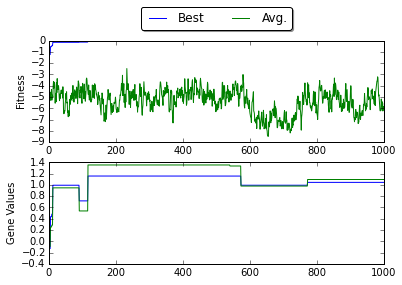

In [59]:
# Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=10,
                          lamb=10,
                          mutation_power=1.0,
                          prob_mutate_gene=0.75):
    if(mu == 0):
        mu = 1
    if(lamb == 0):
        lamb = 1
    global power
    power = mutation_power
    global sigma
    sigma = mutation_power
    global pMutateGene
    pMutateGene = prob_mutate_gene
    winner = evolution(mu, lamb, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10),
                                mutation_power=(0, 10, 0.05),
                                prob_mutate_gene=(0,1, 0.05))

#### 3.3.5. Recombination: Playing Legos with genes

In [60]:
# Creates a new genome by recombining
# the genes of the two given parents
def recombine(parent1, parent2):
    
    # Clone the first parent
    child = parent1.clone()  
    
    # Set the second gene of the child to the value 
    # of the second gene of the second parent
    child.genes[1] = parent2.genes[1] 
    
    # Return the child
    return child 
    
# Takes in a set of parents and produces an equivalent number of offspring
def reproduce(parents): 
 
    # Initialize an empty list of offspring
    offspring = []
    
    # For each parent, create offspring through sexual reproduction
    for parent in parents: 

        # Select a second parent
        parent2 = parents[random.randint(len(parents))]
        
        # Create a child by recombining the genes from parent and parent2
        child = recombine(parent, parent2)
        
        # Set its fitness to a very low value
        child.fitness = -10000 
        
        # Add the child to the offspring list
        offspring.append(child) 
        
    # Return the list of offspring
    return offspring 

Champion -- Genes = [-0.9052636893115222, 0.6953066692658139] Fitness = -1.8201017336


<function __main__.interactive_iteration>

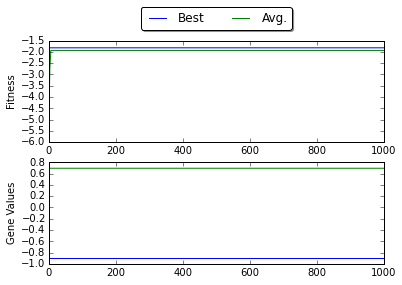

In [61]:
def evaluate(genome):
    genome.fitness = -math.log(abs((100*(genome.genes[0]**2 - genome.genes[1])**2 + (1 - genome.genes[0])**2)) + 1)
      
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10),
                                mutation_power=(0, 10, 0.05),
                                prob_mutate_gene=(0,1, 0.05))

#### Mutation AND Recombination

In [62]:
# Probability of performing
# recombination rather than mutation
pRecombination = 0.5

# Takes in a set of parents and produces 
# an equivalent number of offspring
def reproduce(parents):
    
    # Initialize an empty list of offspring
    offspring = [] 
    
    # For each parent, create offspring 
    for parent in parents: 
        child = None
        
        # If we reproduce through cloning and mutation
        if(random.uniform(0, 1) > pRecombination):
            # Clone the parent
            child = parent.clone();
            # Mutate the clone
            mutate_genome(child)
        # Else we reproduce through recombination
        else:
            # Select a second parent
            parent2 = parents[random.randint(len(parents))]
            # Create a child by recombining the genes from parent and parent2
            child = recombine(parent, parent2) 
            
        # Set child's fitness to a very low value
        child.fitness = -10000 
        # Add the child to the offspring list
        offspring.append(child) 
    
    # Return the list of offspring
    return offspring 

Champion -- Genes = [0.9580940881458754, 0.9181128243773653] Fitness = -0.00175740097628


<function __main__.interactive_iteration>

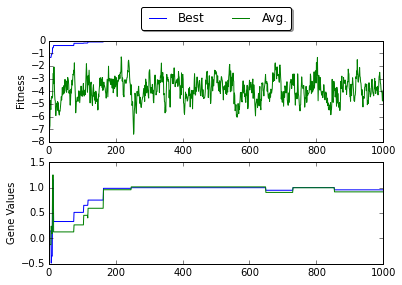

In [63]:
def evaluate(genome):
    genome.fitness = -math.log(abs((100*(genome.genes[0]**2 - genome.genes[1])**2 + (1 - genome.genes[0])**2)) + 1)

    # Function that will perform evolution 
# with the given parameters
def interactive_iteration(generations=1000,
                          mu=10,
                          lamb=10,
                          mutation_power=1.0,
                          prob_mutate_gene=0.75,
                          prob_recombine=0.5):
    if(mu == 0):
        mu = 1
    if(lamb == 0):
        lamb = 1
    global power
    power = mutation_power
    global sigma
    sigma = mutation_power
    global pMutateGene
    pMutateGene = prob_mutate_gene
    global pRecombine
    pRecombine = prob_recombine
    winner = evolution(mu, lamb, generations)

    print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))
    
# Create interactive sliders for parameters
interact(interactive_iteration, generations=(0,10000,10),
                                mu=(0,1000, 10),
                                lamb=(0,1000, 10),
                                mutation_power=(0, 10, 0.05),
                                prob_mutate_gene=(0,1, 0.05),
                                prob_recombine=(0,1,0.05))

### 3.4. (Optional) Advanced Topics: Theory, How to make policies, Co-Evolution, and Prison

#### 3.4.1. Building blocks and Schemas

Champion -- Genes = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] Fitness = 32


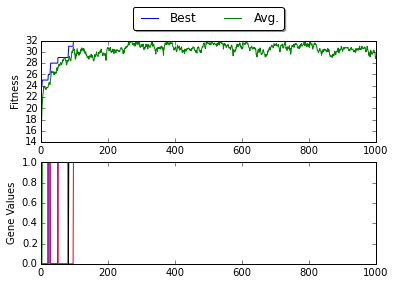

In [64]:
# Number of bits in the genome
numBits = 32 
# Probability of mutating a bit
pMutateGene = 1.0/numBits
# Probability of recombining two genomes
pRecombination = 0.5 
# Population Size
mu = 10 
# Offspring size
lamb = 10 

# Creates and returns a new random genome
def new_genome(): 
    bits = []
    for x in range(numBits):
        bits.append(random.randint(2))
    # A random genome for this domain is array of 0's and 1's
    return Genome(-10000, bits) 

# Mutation takes a genome and alters 
# its genes to create a new solution instance
def mutate_genome(genome): 
    # For the number genes
    for x in range(len(genome.genes)): 
        # If randomly selected number is 
        # below probability of mutating single gene
        if(random.uniform(0, 1) < pMutateGene): 
            # Mutate this gene by flipping 0 to 1, or, 0 to 1
            genome.genes[x] = (genome.genes[x] + 1) % 2 

# Creates offspring by recombining
# the genes of the given parents
def recombine(parent1, parent2):  
    # Clone parent 1
    child = parent1.clone()
    # Choose a point where the child's genes 
    # start to come from parent 2
    crossoverPoint = random.randint(1, len(child.genes)-1) 
    # Set the child genes to parent 1's genes
    # up to the crossover point
    child.genes = child.genes[:crossoverPoint]
    # Complete the child's genes with parent 2's
    # genes after the crossover point
    child.genes.extend(parent2.genes[crossoverPoint:])
    # Return the child
    return child 

# Evaluator that is the OneMax Domain
def evaluate(genome):
    genome.fitness = 0
    # Implementation of OneMax domain 
    # (i.e. maximize the number of 1 bits in the genome)
    # Sums the number of bits set to 1
    for x in genome.genes: 
        genome.fitness += x

winner = evolution(mu, lamb, 1000)
print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))

#### 3.4.2. The Prisoner's Dilemma

In [65]:
def evolution(populationSize, offspringSize, maxGenerations):
    
    currentGeneration = 0 # Current generation being executed
    
    avgFitnessByGeneration = [] # Array to hold generational average fitness values
    bestFitnessByGeneration = [] # Array to hold generational champion fitness values
    championValuesByGeneration = [] # Array to hold generational champion values
    
    population = []  # Initialize an empty population
    bestGenome = None # Set the best genome to a null value
    
    avg = 0.0  # Initialize variable for calculating population average fitness to 0
    for x in range(populationSize): # For the size of the population
        population.append(new_genome()) # Createa new random genome and add it to the population
    for x in range(populationSize): # For the size of the population
        evaluate(population[x], population) # Evaluate each genome against the population
        avg += population[x].fitness # Add its fitness score to the average
        if(bestGenome is None or population[x].fitness > bestGenome.fitness):  # If the best genome hasn't been set, or, this
                                                                               # genome has better fitness
            bestGenome = population[x] # Set the bestGenome to this genome
    
    # Add the metrics to their various arrays for tracking
    avgFitnessByGeneration.append(avg/populationSize)
    bestFitnessByGeneration.append(bestGenome.fitness)
    championValuesByGeneration.append(bestGenome.genes)
    
    while(currentGeneration < maxGenerations): # For the maximum number of generations
        
        parents = select_parents(population, offspringSize) # Select a number of parents equal to the number of offspring to create
        offspring = reproduce(parents) # Create a number of offspring by reproducing the selected parents
        bestGenome = None
        for child in offspring: # For each of the offspring
            evaluate(child, population) # Evaluate the offspring against the existing population
            if(bestGenome is None or child.fitness > bestGenome.fitness): # Update the best genome is applicable
                bestGenome = child
        
        population = select_population(population, offspring) # Select a new population from the current population and offspring
        
        avg = 0.0 # Init average to 0
        for genome in population: # For each genome in the population
            avg += genome.fitness # Add its fitness to the average
   
        # Add the metrics to the various arrays
        avgFitnessByGeneration.append(avg/populationSize)
        bestFitnessByGeneration.append(bestGenome.fitness)
        championValuesByGeneration.append(bestGenome.genes)
        
        currentGeneration += 1 # Increment current generation by one
    
    # Plot the best fitness, average fitness, and the champion gene values by generation
    labels = range(len(bestFitnessByGeneration))
    subplot(2,1,1)
    plot(labels, bestFitnessByGeneration, labels, avgFitnessByGeneration)
    ylabel("Fitness")
    legend(["Best", "Avg."], loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    subplot(2,1,2)
    plot(labels, championValuesByGeneration)
    ylabel("Gene Values")
    
    
    return bestGenome # Return the best genome

In [ ]:
numBits = 5  # Five bits to represent the prisoner's policy, with meaning defect, and 0 meaning cooperate
             # The first bit represents an action to take with no history, followed by history of CC, DC, CD, and DD
rewards = [3, 5, 0, 1] # Rewards for CC, DC, CD, DD
gameIterations = 100

def dilemma(policy, opponent, iterations): # Score a given policy against an opponent for a number of iterations
    score = 0.0 # Initial score of 0
    lastOutcome = 0 # Last outcome with (0 = No history, 1 = CC, 2 = DC, 3 = CD, 4 = DD)
    for x in range(iterations): # For the number of iterations
        policyDecision = policy[lastOutcome] # Get the policy's decision given last outcome
        opponentDecision = opponent[lastOutcome] # Get opponent's decision given last outcome
        lastOutcome = 1 + policyDecision * 1 + opponentDecision * 2 # Set the last outcome
        score += rewards[lastOutcome - 1] # Get the score given the outcome
    return score / iterations # Dive the score by number of iterations

def evaluate(genome, opponents):
    genome.fitness = 0
    for x in opponents: # For each opponent, evaluate the genome against it
        genome.fitness += dilemma(genome.genes, x.genes, gameIterations)
    genome.fitness = genome.fitness / len(opponents) # Divide fitness by number of opponents for an average    

In [ ]:
mu = 100 # Population Size
lamb = 10 # Offspring size
totalGenerations = 1000 # Number of generations of evolution 
pMutateGene = 1.0/numBits # Probability of flipping a bit
pRecombination = 0 # Probability of recombining genomes rather than mutating
rewards = [3, 5, 0, 1] # Rewards for CC, DC, CD, DD
gameIterations = 100 # Number of iterations for the Prisoner's Dilemma

winner = evolution(mu, lamb, totalGenerations)
print("Champion -- Genes = " + str(winner.genes) + " Fitness = " + str(winner.fitness))